# qgan加载随机分布

给定$k$维数据样本，我们使用量子生成对抗网络(qGAN)来了解数据的底层随机分布，并将其直接加载到量子状态:

$$ \big| g_{\theta}\rangle = \sum_{j=0}^{2^n-1} \sqrt{p_{\theta}^{j}}\big| j \rangle $$

其中$p_{\theta}^{j}$描述基状态$\big| j\rangle$的发生概率。

qGAN训练的目的是生成一个状态$\big| g_{\theta}\rangle$，其中$p_{\theta}^{j}$，对于$j\in \left\{0, \ldots, {2^n-1} \right\}$，描述一个概率分布，该分布接近于训练数据$X=\left\{x^0, \ldots, x^{k-1} \right\}$下的分布。

For further details please refer to [Quantum Generative Adversarial Networks for Learning and Loading Random Distributions](https://arxiv.org/abs/1904.00043) _Zoufal, Lucchi, Woerner_ \[2019\].

In [1]:
import numpy as np
seed = 71
np.random.seed = seed

import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import QuantumRegister, QuantumCircuit, BasicAer
from qiskit.circuit.library import TwoLocal, UniformDistribution

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import NumPyDiscriminator, QGAN

algorithm_globals.random_seed = seed

## 加载训练数据

首先，我们需要加载$k$维训练数据样本(这里k=1)。

接下来，设置数据分辨率，即最小/最大数据值和用于表示每个数据维的量子位数。

In [2]:
# 训练数据样本数量
N = 10 
qubitnum = 3

# 加载数据样本来自对数正态分布，均值=1，标准差=1
mu = 1
sigma = 1
real_data = np.random.lognormal(mean=mu, sigma=sigma, size=N)
print(real_data)

# 设置数据范围
# 设置上下数据值为k个最小/最大数据值列表[[min_0,max_0]，…，[min_k-1,max_k-1]]
bounds = np.array([0, (2 ** qubitnum - 1)]) 

# 设置每个数据维度的量子位数为k个量子位值列表[#q_0，…，#q_k-1]
num_qubits = [qubitnum]
k = len(num_qubits) # 1

[ 4.90190411  1.30977772  3.52962788  0.71297701  1.06049297  5.96068416
  6.30382175 17.63682471  0.73687701  3.34779499]


## 初始化qGAN

量子gan由量子发生器$G_{\theta}$(即ansatz)和经典鉴别器$D_{\phi}$(即神经网络)组成。

为了实现量子发生器，我们选择了一个depth-$1$ ansatz，它实现了$R_Y$旋转和$CZ$门，它以均匀分布作为输入状态。值得注意的是，对于$k>1$，生成器的参数必须仔细选择。例如，电路深度应该是$>1$，因为更高的电路深度可以表示更复杂的结构。

这里使用的经典鉴别器是基于使用NumPy的神经网络实现的。还有一个基于PyTorch的识别器，在安装Qiskit时默认不安装它——参见[可选安装](https://github.com/Qiskit/qiskit-machine-learning#optional-installs)了解更多信息。

这里，两个网络都使用ADAM优化算法更新(ADAM是qGAN优化器的默认值)。

In [3]:
# 设置训练epoch次数
# 注:算法的运行时间可以通过减少训练epoch的数量来缩短。
num_epochs = 5
# Batch size
batch_size = int(N / num_epochs)

# 初始化 qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)
qgan.seed = 1
# 设置量子硬件运行量子生成器
quantum_instance = QuantumInstance(backend=BasicAer.get_backend('statevector_simulator'),
                                   seed_transpiler=seed, seed_simulator=seed)

# 设置纠缠 map
entangler_map = [[0, 1]]

#设置电路的初始状态
init_dist = UniformDistribution(sum(num_qubits))

# 设置ansatz电路
ansatz = TwoLocal(int(np.sum(num_qubits)), 'ry', 'cz', entanglement=entangler_map, reps=1)

#设置电路初始参数 - 为了减少训练时间，从而减少这个笔记本的总运行时间
#init_params = [3., 1., 0.6, 1.6]

# 您可以增加训练周期的数量并使用随机初始参数。
init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi

# 通过在ansatz前面添加初始分布来设置电路分布
g_circuit = ansatz.compose(init_dist, front=True)

# 设置量子生成器
qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)
# 参数有一个顺序问题，下面是一个临时的解决办法
qgan._generator._free_parameters = sorted(g_circuit.parameters, key=lambda p: p.name)
# 设置经典判别器神经网络
discriminator = NumPyDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)

<ipython-input-3-13b2690560fc>:18: DeprecationWarning: `UniformDistribution` is deprecated as of version 0.17.0 and will be removed no earlier than 3 months after the release date. It moved to qiskit_finance.circuit.library.UniformDistribution.
  init_dist = UniformDistribution(sum(num_qubits))


## 运行qGAN培训

在训练过程中，鉴别器和生成器的参数交替更新为以下损失函数:
$$ L_G\left(\phi, \theta\right) = -\frac{1}{m}\sum\limits_{l=1}^{m}\left[\log\left(D_{\phi}\left(g^{l}\right)\right)\right] $$和
$$  L_D\left(\phi, \theta\right) =
	\frac{1}{m}\sum\limits_{l=1}^{m}\left[\log D_{\phi}\left(x^{l}\right) + \log\left(1-D_{\phi}\left(g^{l}\right)\right)\right] $$,
其中$m$表示批大小，$g^l$表示量子发生器生成的数据样本。

请注意，为了便于编写本手册，通过选择一个已知的初始点(' init_params ')，使培训更加简洁。没有这些事先的知识，要知道培训可能需要一些时间。

In [4]:
# Run qGAN
result = qgan.run(quantum_instance)

In [5]:
print('Training results:')
for key, value in result.items():
    print(f'  {key} : {value}')

Training results:
  params_d : [ 0.03047165  0.61668622 -0.48484985 ... -0.17245303 -0.19535628
 -0.09334295]
  params_g : [ 1.09666121e+00  1.94444050e+00  1.26898824e+00  3.72613984e+00
 -2.54698490e-03  1.32871668e+00]
  loss_d : 0.6807
  loss_g : [1.3116]
  rel_entr : 8.2443


## 培训进度和结果

现在，我们绘制出在训练过程中发生器和鉴别器的损失函数的演化，以及训练后的相对熵与目标分布之间的变化。

最后，我们还比较了训练分布的累积分布函数(CDF)和目标分布的累积分布函数。

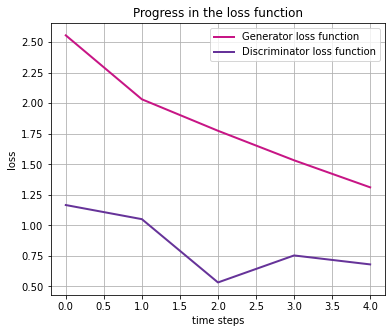

In [6]:
# 绘制w.r.t生成器和鉴别器的损失函数
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6,5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss, label='Generator loss function', color='mediumvioletred', linewidth=2)
plt.plot(t_steps, qgan.d_loss, label='Discriminator loss function', color='rebeccapurple', linewidth=2)
plt.grid()
plt.legend(loc='best')
plt.xlabel('time steps')
plt.ylabel('loss')
plt.show()

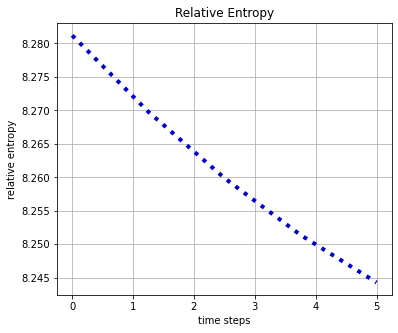

In [7]:
# Plot progress w.r.t relative entropy
plt.figure(figsize=(6,5))
plt.title('Relative Entropy')
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr)), qgan.rel_entr, color='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

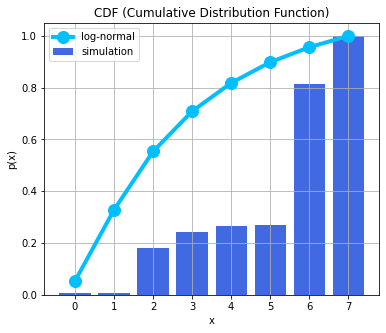

In [8]:
# 绘制结果分布的CDF与目标分布，即对数正态分布
log_normal = np.random.lognormal(mean=1, sigma=1, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1] + 1)):
    temp += [np.sum(log_normal==i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6,5))
plt.title('CDF (Cumulative Distribution Function)')
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g,  np.cumsum(prob_g), color='royalblue', width= 0.8, label='simulation')
plt.plot( np.cumsum(log_normal),'-o', label='log-normal', color='deepskyblue', linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g)+1, 1.0))
plt.grid()
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc='best')
plt.show()

In [9]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

D:\Anaconda\lib\site-packages\qiskit\aqua\__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
